# Clustering - Introduction
This notebook is a third part of [eargasm-spotify](https://github.com/adamsiemaszkiewicz/eargasm-music) repository meant to cluster the playlist and track information from the [eargasm music channel](https://open.spotify.com/user/eargasmusic?si=HtTLbkG6QoqkdKU3uTRjAQ) at Spotify.

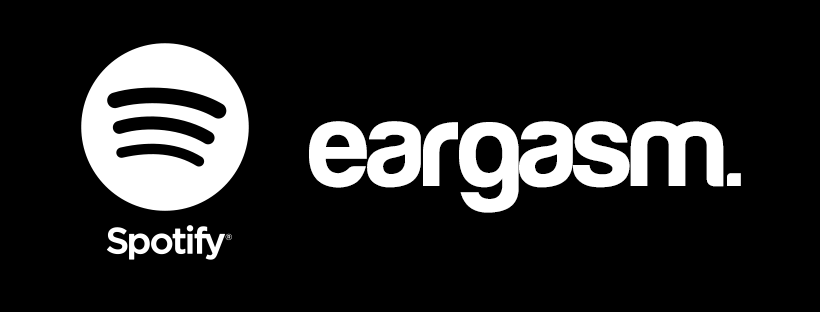

# Set up environment

## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/Colab Notebooks/eargasm-music/

/content/gdrive/My Drive/Colab Notebooks/eargasm-music


In [3]:
!ls

catboost_info		      eargasm_DataExploration.ipynb  files
eargasm_Classification.ipynb  eargasm_DataRetrieval.ipynb    README.md


In [4]:
!pip install category_encoders

## Import libraries and functions
Let's import all the libraries and function we're gonna use throughout the notebook.

### Notebook
- `tqdm.notebook` `tqdm` - Progress bars

In [5]:
from tqdm.notebook import tqdm

### Data science
- `pandas` - data manipulation & analysis
- `pd.options.mode.chained_assignment` - switch off warning for chained_assignment
- `numpy` - linear algebra

In [6]:
import pandas as pd
import numpy as np

### Visualization
- `matplotlib.pyplot` - basic visualizations
- `plotly` - advanced visualizations
- `plotly.express` - fast vizualizations
- `plotly.graph_objects` - more control over plotly figures

In [7]:
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

## Machine learning

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import category_encoders as ce


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Load data
Let's load the data fetched from the [Eargasm Music](https://open.spotify.com/user/eargasmusic?si=cz4VzEi1RgaUup_g8-UnEg) Spotify channel using `eargasm_retrieve-data.ipynb`. The data set consists of the tracks with their features as well as a playlist name label.

In [9]:
final_df = pd.read_csv('files/final_df.csv', index_col=0)
final_df.head()

,track_id,track_artist,track_artistid,track_name,track_duration,track_popularity,track_releasedate,track_preview,track_image,track_url,track_playlist,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,key_confidence,mode,mode_confidence,number_of_sections,tempo,tempo_confidence,time_signature,time_signature_confidence
0,1ua6hBq18qZLyprXjMcpyf,Virgil Howe,6d3Hil7Y1xq0oEhtaDxEUg,Someday,251266,42,2009-10-19,https://p.scdn.co/mp3-preview/a2bdcba6acda937f...,https://i.scdn.co/image/ab67616d0000b27356dc5e...,https://open.spotify.com/track/1ua6hBq18qZLypr...,eargasm | breathe easy,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.292,0.0,0.398,12.0,86.502,0.160,4.0,1.000
1,42VpxSdGQgnV1UJkWeGYkA,Cass McCombs,2iUVQjheBnvOt8vaBrxXJz,Switch,254233,51,2016-08-26,https://p.scdn.co/mp3-preview/d0feea85b84ce9f5...,https://i.scdn.co/image/ab67616d0000b27396782c...,https://open.spotify.com/track/42VpxSdGQgnV1UJ...,eargasm | breathe easy,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.743,0.0,0.453,12.0,98.003,0.583,4.0,1.000
2,1g8A166soQjwl1ihqBWKGW,The Slow Revolt,7cfCmW2AFiMNdpJdY0vJsr,Lean,207699,0,2016-09-09,NaN,https://i.scdn.co/image/ab67616d0000b273ce48d6...,https://open.spotify.com/track/1g8A166soQjwl1i...,eargasm | breathe easy,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,0.655,1.0,0.368,12.0,85.036,0.325,4.0,0.979
3,6cAVWcj8TQ5yR2T6BZjnOg,Dirty Nice,4MGA6AM4iZ2HYc6b77og9g,Zero Summer,212640,0,2017-06-09,NaN,https://i.scdn.co/image/ab67616d0000b2733a028c...,https://open.spotify.com/track/6cAVWcj8TQ5yR2T...,eargasm | breathe easy,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,0.547,1.0,0.560,12.0,125.088,0.476,4.0,0.845
4,3YA509E9ki7a3Ic9cf25Vt,Alex Ebert,1me05HW5s7TShHra5nN7uE,Broken Record,274800,47,2017-05-05,https://p.scdn.co/mp3-preview/96c62ba3b9d730d3...,https://i.scdn.co/image/ab67616d0000b2738a6904...,https://open.spotify.com/track/3YA509E9ki7a3Ic...,eargasm | breathe easy,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,0.905,1.0,0.753,12.0,170.556,0.183,4.0,0.799


# Feature extraction

In [10]:
features_to_keep = [
                    # 'track_artist',
                    'track_duration',
                    'track_popularity',
                    # 'track_releasedate',
                    'track_genre',
                    'acousticness',
                    'danceability',
                    'energy',
                    'instrumentalness',
                    'liveness',
                    'speechiness',
                    'valence',
                    'key',
                    # 'key_confidence',
                    'mode',
                    # 'mode_confidence',
                    # 'number_of_sections',
                    'tempo',
                    # 'tempo_confidence',
                    'time_signature',
                    # 'time_signature_confidence'
                    ]
X = final_df[features_to_keep]
y = final_df['track_playlist']

In [11]:
X.head()

,track_duration,track_popularity,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,mode,tempo,time_signature
0,251266,42,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0
1,254233,51,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0
2,207699,0,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0
3,212640,0,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0
4,274800,47,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0


# Feature engineering

In [12]:
X_decoded = X.copy()

## Functions

In [13]:
def cut_into_categories(feature_name, number_of_categories):

  X_decoded[feature_name] = X[feature_name]  
  X_decoded[feature_name] = pd.cut(X_decoded[feature_name], number_of_categories)

  ranges = X_decoded[feature_name].unique()
  ranges.sort_values(inplace=True)

  for n, value in enumerate(ranges):
    X_decoded.loc[X_decoded[feature_name] == value, feature_name+'_de'] = n+1

  # X_decoded[feature_name+'_de'] = X_decoded[feature_name+'_de'].astype(int)
  X_decoded.drop(columns=[feature_name], inplace=True)

  return X_decoded

In [14]:
def fill_nans(feature_name):
  X_decoded[feature_name].fillna(int(X_decoded[feature_name].mean()), inplace=True)
  X_decoded[feature_name+'_de'] = X_decoded[feature_name].apply(lambda x: int(x))
  X_decoded.drop(columns=[feature_name], inplace=True)
  return X_decoded

## `track_duration`

In [15]:
X_decoded['track_duration'] = final_df['track_duration'] # reset value
X_decoded['track_duration'] = X_decoded['track_duration'].apply(lambda x: x/60000)

cut_into_categories('track_duration', 10).head()

,track_popularity,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,mode,tempo,time_signature,track_duration_de
0,42,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0,4.0
1,51,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0,4.0
2,0,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0,3.0
3,0,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0,3.0
4,47,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0,4.0


## `track_popularity`


In [16]:
cut_into_categories('track_popularity', 7).head()

,track_genre,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de
0,NaN,0.370,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0,4.0,4.0
1,alternative country,0.362,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0,4.0,5.0
2,vapor pop,0.195,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0,3.0,1.0
3,NaN,0.742,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0,3.0,1.0
4,alternative americana,0.240,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0,4.0,5.0


## `acousticness`

In [17]:
cut_into_categories('acousticness', 10).head()

,track_genre,danceability,energy,instrumentalness,liveness,speechiness,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de
0,NaN,0.483,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0,4.0,4.0,4.0
1,alternative country,0.682,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0,4.0,5.0,4.0
2,vapor pop,0.536,0.753,0.801000,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0,3.0,1.0,2.0
3,NaN,0.663,0.509,0.000006,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0,3.0,1.0,8.0
4,alternative americana,0.464,0.570,0.001210,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0,4.0,5.0,3.0


## `danceability`

In [18]:
cut_into_categories('danceability', 7).head()

,track_genre,energy,instrumentalness,liveness,speechiness,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de
0,NaN,0.462,0.210000,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0,4.0,4.0,4.0,4.0
1,alternative country,0.538,0.000123,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0,4.0,5.0,4.0,5.0
2,vapor pop,0.753,0.801000,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0,3.0,1.0,2.0,4.0
3,NaN,0.509,0.000006,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0,3.0,1.0,8.0,5.0
4,alternative americana,0.570,0.001210,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0,4.0,5.0,3.0,4.0


## `energy`

In [19]:
cut_into_categories('energy', 10).head()

,track_genre,instrumentalness,liveness,speechiness,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de
0,NaN,0.210000,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0,4.0,4.0,4.0,4.0,5.0
1,alternative country,0.000123,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0,4.0,5.0,4.0,5.0,6.0
2,vapor pop,0.801000,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0,3.0,1.0,2.0,4.0,8.0
3,NaN,0.000006,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0,3.0,1.0,8.0,5.0,6.0
4,alternative americana,0.001210,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0,4.0,5.0,3.0,4.0,6.0


## `instrumentalness`

In [20]:
cut_into_categories('instrumentalness', 10).head()

,track_genre,liveness,speechiness,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de
0,NaN,0.0875,0.0290,0.351,9.0,0.0,86.502,4.0,4.0,4.0,4.0,4.0,5.0,3.0
1,alternative country,0.3240,0.0283,0.713,7.0,0.0,98.003,4.0,4.0,5.0,4.0,5.0,6.0,1.0
2,vapor pop,0.1200,0.0309,0.676,1.0,1.0,85.036,4.0,3.0,1.0,2.0,4.0,8.0,9.0
3,NaN,0.1120,0.0889,0.303,11.0,1.0,125.088,4.0,3.0,1.0,8.0,5.0,6.0,1.0
4,alternative americana,0.1380,0.0400,0.548,0.0,1.0,170.556,4.0,4.0,5.0,3.0,4.0,6.0,1.0


## `liveness`

In [21]:
cut_into_categories('liveness', 10).head()

,track_genre,speechiness,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de
0,NaN,0.0290,0.351,9.0,0.0,86.502,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0
1,alternative country,0.0283,0.713,7.0,0.0,98.003,4.0,4.0,5.0,4.0,5.0,6.0,1.0,4.0
2,vapor pop,0.0309,0.676,1.0,1.0,85.036,4.0,3.0,1.0,2.0,4.0,8.0,9.0,2.0
3,NaN,0.0889,0.303,11.0,1.0,125.088,4.0,3.0,1.0,8.0,5.0,6.0,1.0,1.0
4,alternative americana,0.0400,0.548,0.0,1.0,170.556,4.0,4.0,5.0,3.0,4.0,6.0,1.0,2.0


## `speechiness`

In [22]:
cut_into_categories('speechiness', 6).head()

,track_genre,valence,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de,speechiness_de
0,NaN,0.351,9.0,0.0,86.502,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,1.0
1,alternative country,0.713,7.0,0.0,98.003,4.0,4.0,5.0,4.0,5.0,6.0,1.0,4.0,1.0
2,vapor pop,0.676,1.0,1.0,85.036,4.0,3.0,1.0,2.0,4.0,8.0,9.0,2.0,1.0
3,NaN,0.303,11.0,1.0,125.088,4.0,3.0,1.0,8.0,5.0,6.0,1.0,1.0,1.0
4,alternative americana,0.548,0.0,1.0,170.556,4.0,4.0,5.0,3.0,4.0,6.0,1.0,2.0,1.0


## `valence`

In [23]:
cut_into_categories('valence', 10).head()

,track_genre,key,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de,speechiness_de,valence_de
0,NaN,9.0,0.0,86.502,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,1.0,4.0
1,alternative country,7.0,0.0,98.003,4.0,4.0,5.0,4.0,5.0,6.0,1.0,4.0,1.0,8.0
2,vapor pop,1.0,1.0,85.036,4.0,3.0,1.0,2.0,4.0,8.0,9.0,2.0,1.0,7.0
3,NaN,11.0,1.0,125.088,4.0,3.0,1.0,8.0,5.0,6.0,1.0,1.0,1.0,4.0
4,alternative americana,0.0,1.0,170.556,4.0,4.0,5.0,3.0,4.0,6.0,1.0,2.0,1.0,6.0


## `key`

In [24]:
fill_nans('key').head()

,track_genre,mode,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de,speechiness_de,valence_de,key_de
0,NaN,0.0,86.502,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,1.0,4.0,9
1,alternative country,0.0,98.003,4.0,4.0,5.0,4.0,5.0,6.0,1.0,4.0,1.0,8.0,7
2,vapor pop,1.0,85.036,4.0,3.0,1.0,2.0,4.0,8.0,9.0,2.0,1.0,7.0,1
3,NaN,1.0,125.088,4.0,3.0,1.0,8.0,5.0,6.0,1.0,1.0,1.0,4.0,11
4,alternative americana,1.0,170.556,4.0,4.0,5.0,3.0,4.0,6.0,1.0,2.0,1.0,6.0,0


## `mode`

In [25]:
fill_nans('mode').head()

,track_genre,tempo,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de,speechiness_de,valence_de,key_de,mode_de
0,NaN,86.502,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,1.0,4.0,9,0
1,alternative country,98.003,4.0,4.0,5.0,4.0,5.0,6.0,1.0,4.0,1.0,8.0,7,0
2,vapor pop,85.036,4.0,3.0,1.0,2.0,4.0,8.0,9.0,2.0,1.0,7.0,1,1
3,NaN,125.088,4.0,3.0,1.0,8.0,5.0,6.0,1.0,1.0,1.0,4.0,11,1
4,alternative americana,170.556,4.0,4.0,5.0,3.0,4.0,6.0,1.0,2.0,1.0,6.0,0,1


## `tempo`

In [26]:
X_decoded['tempo'].fillna(int(X_decoded['tempo'].mean()), inplace=True)
# X_decoded[X_decoded['tempo'] == 0] = X_decoded['tempo'].mean()
# X_decoded['tempo'] = X_decoded['tempo'].astype(int)
cut_into_categories('tempo', 15).head()
# X_decoded['tempo'].isnull().values.any()
# X_decoded['tempo'].isnull().sum()
# X_decoded['tempo'].sort_values(ascending=False)


,track_genre,time_signature,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de,speechiness_de,valence_de,key_de,mode_de,tempo_de
0,NaN,4.0,4.0,4.0,4.0,4.0,5.0,3.0,1.0,1.0,4.0,9,0,4.0
1,alternative country,4.0,4.0,5.0,4.0,5.0,6.0,1.0,4.0,1.0,8.0,7,0,5.0
2,vapor pop,4.0,3.0,1.0,2.0,4.0,8.0,9.0,2.0,1.0,7.0,1,1,4.0
3,NaN,4.0,3.0,1.0,8.0,5.0,6.0,1.0,1.0,1.0,4.0,11,1,7.0
4,alternative americana,4.0,4.0,5.0,3.0,4.0,6.0,1.0,2.0,1.0,6.0,0,1,10.0


## `time_signature`

In [27]:
fill_nans('time_signature').head()

,track_genre,track_duration_de,track_popularity_de,acousticness_de,danceability_de,energy_de,instrumentalness_de,liveness_de,speechiness_de,valence_de,key_de,mode_de,tempo_de,time_signature_de
0,NaN,4.0,4.0,4.0,4.0,5.0,3.0,1.0,1.0,4.0,9,0,4.0,4
1,alternative country,4.0,5.0,4.0,5.0,6.0,1.0,4.0,1.0,8.0,7,0,5.0,4
2,vapor pop,3.0,1.0,2.0,4.0,8.0,9.0,2.0,1.0,7.0,1,1,4.0,4
3,NaN,3.0,1.0,8.0,5.0,6.0,1.0,1.0,1.0,4.0,11,1,7.0,4
4,alternative americana,4.0,5.0,3.0,4.0,6.0,1.0,2.0,1.0,6.0,0,1,10.0,4


# Dummies

In [28]:
dummies={}
for column in X_decoded.columns:
  dummies[column] = pd.get_dummies(X_decoded[column])

dummy_variables = pd.concat([df for name, df in dummies.items()], axis = 1)
dummy_variables.head()

,a cappella,abstract,abstract beats,abstract hip hop,abstractro,acid house,acid techno,african electronic,afro house,afrobeat,afrofuturism,afroswing,ai,alaska indie,album rock,albuquerque indie,alternative americana,alternative country,alternative dance,alternative emo,alternative hip hop,alternative r&b,alternative rock,ambeat,ambient,ambient folk,ambient house,ambient idm,ambient pop,ambient techno,ambient worship,american post-rock,anti-folk,argentine ambient,art pop,asheville indie,auckland indie,aussietronica,austindie,australian alternative pop,...,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,0,1,2,3,4,5,6,7,8,9,10,11,0,1,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,0,1,3,4,5
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [29]:
y = y.astype('category')
y = y.cat.codes
y

0        0
1        0
2        0
3        0
4        0
        ..
3616    28
3617    28
3618    28
3619    28
3620    28
Length: 3621, dtype: int8

In [35]:
X_decoded.dtypes

track_genre             object
track_duration_de      float64
track_popularity_de    float64
acousticness_de        float64
danceability_de        float64
energy_de              float64
instrumentalness_de    float64
liveness_de            float64
speechiness_de         float64
valence_de             float64
key_de                   int64
mode_de                  int64
tempo_de               float64
time_signature_de        int64
dtype: object

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_decoded,
                                                    y,
                                                    random_state=123456)

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

clf = make_pipeline(StandardScaler(),
                    svm.SVC(gamma='auto'))
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

ValueError: ignored

### Track artist and genre

In [ ]:
# encoder = ce.BinaryEncoder(cols=['track_artist', 'track_genre'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

### Duration & tempo

In [ ]:
# X_encoded['track_duration'] = X_encoded['track_duration'].apply(lambda x: int(x/1000))

# X_encoded['tempo'].fillna(X_encoded['tempo'].mean(), inplace=True)
# X_encoded['tempo'] = X_encoded['tempo'].apply(lambda x: int(x))
# X_encoded.head()

### Release date

In [ ]:
# X_encoded['track_releasedate_year'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).year)
# X_encoded['track_releasedate_month'] = X_encoded['track_releasedate'].apply(lambda x: pd.to_datetime(x).month)
# X_encoded.drop(columns=['track_releasedate'], inplace=True)
# X_encoded.head()

### Key


In [ ]:
# encoder = ce.OneHotEncoder(cols=['key', 'mode', 'number_of_sections', 'time_signature'])
# X_encoded = encoder.fit_transform(X_encoded)

# X_encoded.head()

In [ ]:
# features=['key', 'mode', 'tempo', 'time_signature']
# for feat in features:
#   X_encoded[feat].fillna(X_encoded[feat].mean(), inplace=True)

## Labels

In [ ]:
# y = y.astype('category')
# y = y.cat.codes
# y

# Set split

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_encoded,
#                                                     y,
#                                                     random_state=123456)

## track_artist

In [ ]:
# knn = KNeighborsClassifier()
# knn.fit(X_train, y_train)
# knn.score(X_test, y_test)

In [ ]:
# !pip install catboost

In [ ]:
# from catboost import CatBoostClassifier
# model=CatBoostClassifier()
# model.fit(X_train,y_train)
# model.score(X_test, y_test)

In [ ]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import make_pipeline

# clf = make_pipeline(StandardScaler(),
#                     SGDClassifier(max_iter=1000, tol=1e-3))
# clf.fit(X_train, y_train)

# clf.score(X_test, y_test)

In [ ]:
# from sklearn import svm

# clf = make_pipeline(StandardScaler(),
#                     svm.SVC(gamma='auto'))
# clf.fit(X_train, y_train)

# clf.score(X_test, y_test)

# References
- https://contrib.scikit-learn.org/category_encoders/
- https://www.datacamp.com/community/tutorials/categorical-data
- https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
- https://opendatascience.com/a-machine-learning-deep-dive-into-my-spotify-data/
- https://www.kaggle.com/lowkimhoe/prediction-model-on-spotify-classification